# Week 16 Classification 
Making predictions from past examples.  We are given some examples where we have been told what the correct prediction was, and we want to learn from those examples how to make good predictions in the future. We call it a Classification task since the result is yes or no questions.
<br>
Each record is an observation with many attributes and a class which is yes or no.  We look for patterns in the data (lots of data that gives us examples of both classifications)


In [2]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from urllib.request import urlopen 
import re
def read_url(url): 
    return re.sub('\\s+', ' ', urlopen(url).read().decode())

# Nearest Neighbors
We will use the Chronic Kidney Disease data set which has lab results and whether the person has chronic kidney disease.


In [3]:
ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,1
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,1
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,1
68,80,1.01,3,2,normal,abnormal,present,present,157,90,4.1,130,6.4,5.6,16,11000,2.6,yes,yes,yes,poor,yes,no,1
61,80,1.015,2,0,abnormal,abnormal,notpresent,notpresent,173,148,3.9,135,5.2,7.7,24,9200,3.2,yes,yes,yes,poor,yes,yes,1
48,80,1.025,4,0,normal,abnormal,notpresent,notpresent,95,163,7.7,136,3.8,9.8,32,6900,3.4,yes,no,no,good,no,yes,1
69,70,1.01,3,4,normal,abnormal,notpresent,notpresent,264,87,2.7,130,4,12.5,37,9600,4.1,yes,yes,yes,good,yes,no,1
73,70,1.005,0,0,normal,normal,notpresent,notpresent,70,32,0.9,125,4,10,29,18900,3.5,yes,yes,no,good,yes,no,1
73,80,1.02,2,0,abnormal,abnormal,notpresent,notpresent,253,142,4.6,138,5.8,10.5,33,7200,4.3,yes,yes,yes,good,no,no,1
46,60,1.01,1,0,normal,normal,notpresent,notpresent,163,92,3.3,141,4,9.8,28,14600,3.2,yes,yes,no,good,no,no,1


Some variable are categorical (abnormal, normal, notpresent, present, yes or no, good and poor).  Other columns are quantitative with numbers.  Since the values have different units we will work with standard units.

In [4]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

In [5]:
ckd = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('Hemoglobin')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'White Blood Cell Count', standard_units(ckd.column('White Blood Cell Count')),
    'Class', ckd.column('Class')
)

In [6]:
ckd

Hemoglobin,Glucose,White Blood Cell Count,Class
-0.865744,-0.221549,-0.569768,1
-1.45745,-0.947597,1.16268,1
-1.00497,3.84123,-1.27558,1
-2.81488,0.396364,0.809777,1
-2.08395,0.643529,0.232293,1
-1.35303,-0.561402,-0.505603,1
-0.413266,2.04928,0.360623,1
-1.28342,-0.947597,3.34429,1
-1.10939,1.87936,-0.409356,1
-1.35303,0.489051,1.96475,1


# Visualize two variables and the classification variable
homoglobin level and blood glucose levels 

In [7]:
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
ckd = ckd.join('Class', color_table)

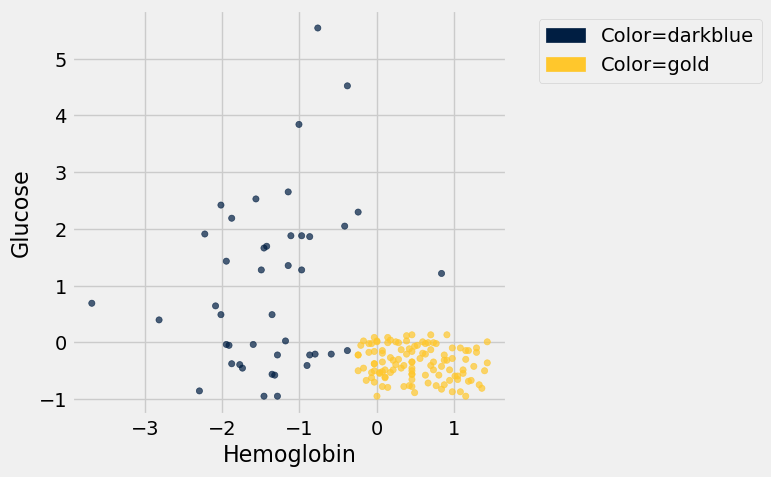

In [8]:
ckd.scatter('Hemoglobin', 'Glucose', group='Color')

# Analysis
Data that is gold represents patients who do not have chronic kidney disease.  So if we know the hemoglobin level and glucose we can predict whether they have chronic kidney disease.  We find the distance from the nearest chronic kidney disease point and the non-chronic kidney disease.  Which ever one is closes is what we will predict her kidney status.

In [9]:
def distance(point1, point2):
    """The distance between two arrays of numbers."""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, point):
    """The distance between p (an array of numbers) and the numbers in row i of attribute_table."""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(point, np.array(row))
    return attributes.apply(distance_from_point)

def table_with_distances(training, point):
    """A copy of the training table with the distance from each row to array p."""
    return training.with_column('Distance', all_distances(training, point))

def closest(training, point, k):
    """A table containing the k closest rows in the training table to array p."""
    with_dists = table_with_distances(training, point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def majority(topkclasses):
    """1 if the majority of the "Class" column is 1s, and 0 otherwise."""
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, p, k):
    """Classify an example with attributes p using k-nearest neighbor classification with the given training table."""
    closestk = closest(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

def show_closest(point):
    """point = array([x,y]) 
    gives the coordinates of a new point
    shown in red"""
    
    HemoGl = ckd.drop('White Blood Cell Count', 'Color')
    t = closest(HemoGl, point, 1)
    x_closest = t.row(0).item(1)
    y_closest = t.row(0).item(2)
    ckd.scatter('Hemoglobin', 'Glucose', group='Color')
    plots.scatter(point.item(0), point.item(1), color='red', s=30)
    plots.plot(make_array(point.item(0), x_closest), make_array(point.item(1), y_closest), color='k', lw=2);

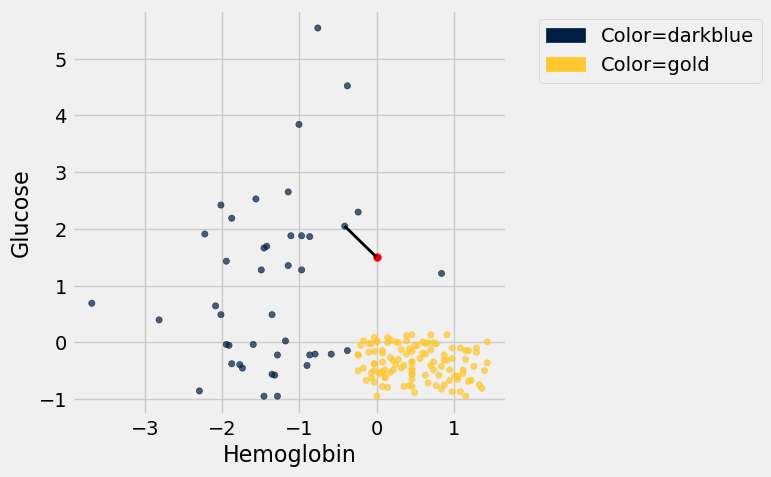

In [10]:
# In this example, Alice's Hemoglobin attribute is 0 and her Glucose is 1.5.
alice = make_array(0, 1.5)
show_closest(alice)

Thus our nearest neighbor classifier works like this:

- Find the point in the training set that is nearest to the new point.

- If that nearest point is a “CKD” point, classify the new point as “CKD”. If the nearest point is a “not CKD” point, classify the new point as “not CKD”.

# Decision Boundary
a line called a decision boundary where values on one side of line are chronic kidney disease and the side are non-chronic kidney disease.

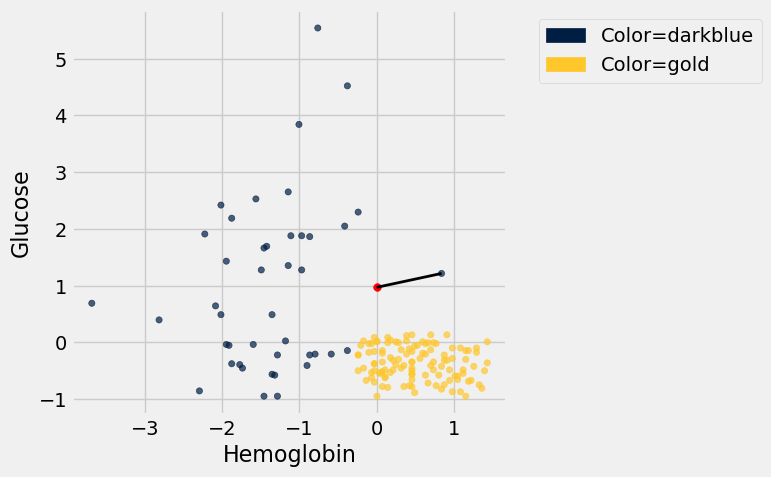

In [11]:
alice = make_array(0, 0.97)
show_closest(alice)

# k-Nearest Neighbors


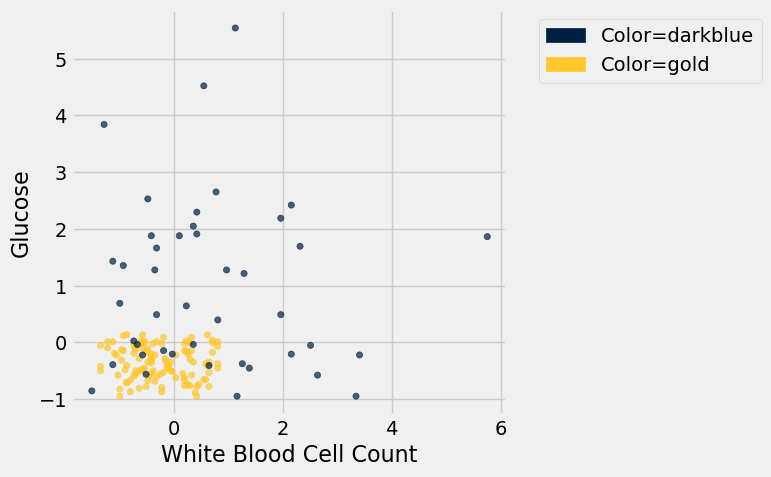

In [12]:
ckd.scatter('White Blood Cell Count', 'Glucose', group='Color')

k is odd to prevent ties.  We predict based on k patients with the closest points to new blood test for glucose, hemoglobin, and whit blood cell count.

# Training and Testing
How often are our classifications correct.  We want to make predictions on new patients not in the training data set.  We divide the data set into two data sets training and testing.  We will determine the percentage of data that is correct.
<br>
We will separate the data set using a random sample into two data sets: training and testing.  We also have another group without a classification.  Shuffle the data set and separate the data into two parts.


In [13]:
shuffled_ckd = ckd.sample(with_replacement=False)
training = shuffled_ckd.take(np.arange(79))
testing = shuffled_ckd.take(np.arange(79, 158))

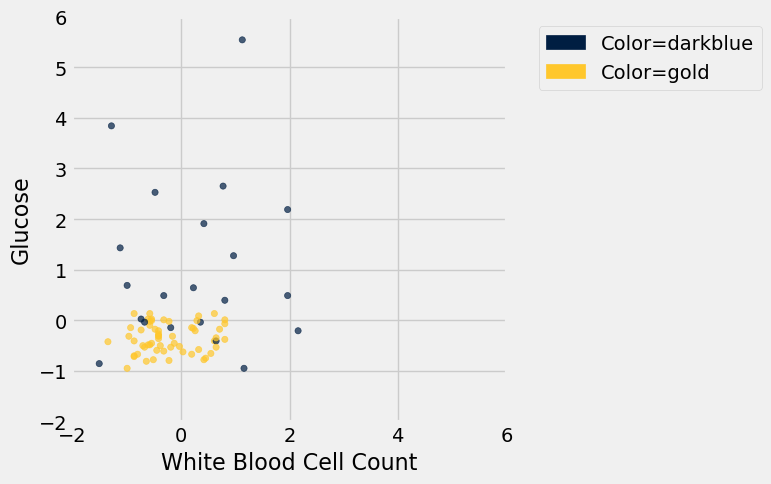

In [14]:
training.scatter('White Blood Cell Count', 'Glucose', group='Color')
plots.xlim(-2, 6)
plots.ylim(-2, 6);

# Using test data set k-nearest neighbor boundary
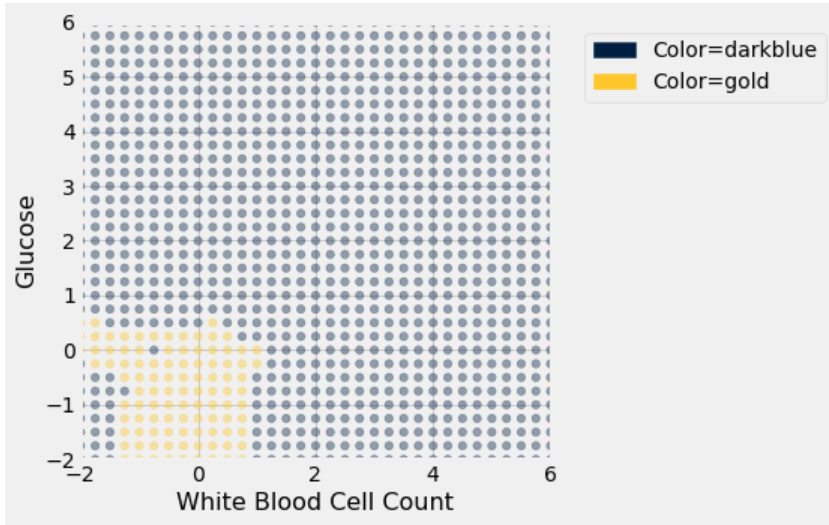

# place testing data points on graph to see how they will be predicted.
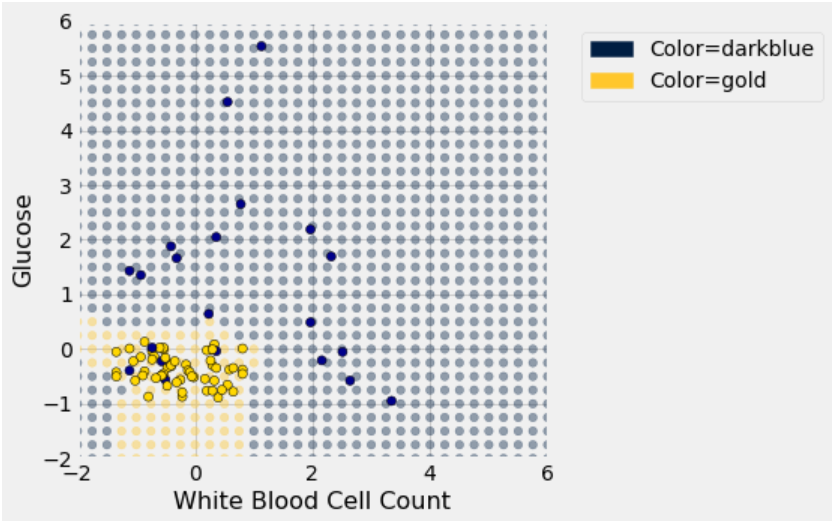

# Rows of Tables

In [15]:
ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd.row(0)

Row(Age=48, Blood Pressure=70, Specific Gravity=1.0049999999999999, Albumin=4, Sugar=0, Red Blood Cells='normal', Pus Cell='abnormal', Pus Cell clumps='present', Bacteria='notpresent', Glucose=117, Blood Urea=56, Serum Creatinine=3.7999999999999998, Sodium=111, Potassium=2.5, Hemoglobin=11.199999999999999, Packed Cell Volume=32, White Blood Cell Count=6700, Red Blood Cell Count=3.8999999999999999, Hypertension='yes', Diabetes Mellitus='no', Coronary Artery Disease='no', Appetite='poor', Pedal Edema='yes', Anemia='yes', Class=1)

# Row select values of a specific record
we can access various values of the record by using the item method.


In [16]:
ckd.row(0).item(3)

4

# Converting Rows to Arrays 
Numerical data or all string can be converted to an arrays.

In [17]:
ckd = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('Hemoglobin')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'Class', ckd.column('Class')
)

color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
ckd = ckd.join('Class', color_table)
ckd

Class,Hemoglobin,Glucose,Color
0,0.456884,0.133751,gold
0,1.153,-0.947597,gold
0,0.770138,-0.762223,gold
0,0.596108,-0.190654,gold
0,-0.239236,-0.49961,gold
0,-0.0304002,-0.159758,gold
0,0.282854,-0.00527964,gold
0,0.108824,-0.623193,gold
0,0.0740178,-0.515058,gold
0,0.83975,-0.422371,gold


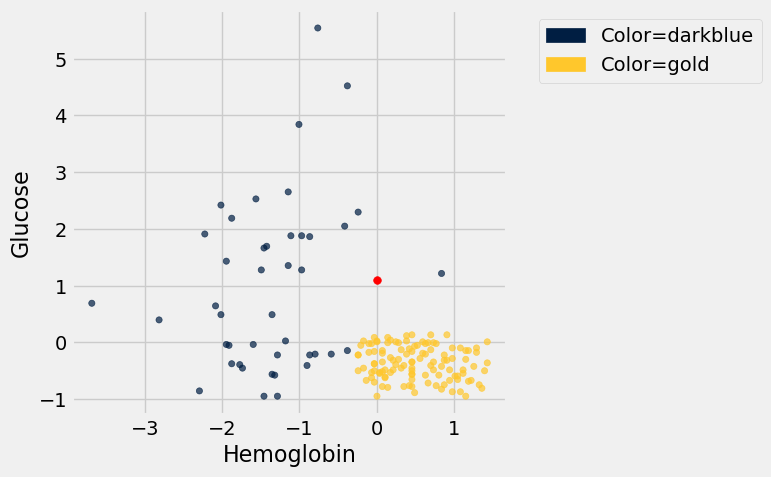

In [18]:
alice = make_array(0, 1.1)
ckd.scatter('Hemoglobin', 'Glucose', group='Color')
plots.scatter(alice.item(0), alice.item(1), color='red', s=30);

In [19]:
ckd_attributes = ckd.select('Hemoglobin', 'Glucose')
ckd_attributes

Hemoglobin,Glucose
0.456884,0.133751
1.153,-0.947597
0.770138,-0.762223
0.596108,-0.190654
-0.239236,-0.49961
-0.0304002,-0.159758
0.282854,-0.00527964
0.108824,-0.623193
0.0740178,-0.515058
0.83975,-0.422371


In [20]:
ckd_attributes.row(3)

Row(Hemoglobin=0.59610766482326683, Glucose=-0.19065363034327712)

In [21]:
np.array(ckd_attributes.row(3))

array([ 0.59610766, -0.19065363])

# Distance Between Points When There are Two Attributes
The distance between two points is....<br>
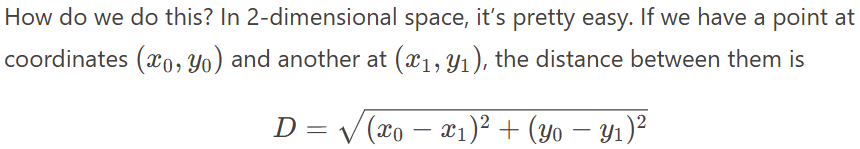



In [22]:
patient3 = np.array(ckd_attributes.row(3))
alice, patient3

(array([ 0. ,  1.1]), array([ 0.59610766, -0.19065363]))

In [23]:
distance = np.sqrt(np.sum((alice - patient3)**2))
distance

1.4216649188818471

In [24]:
def distance(point1, point2):
    """Returns the Euclidean distance between point1 and point2.
    
    Each argument is an array containing the coordinates of a point."""
    return np.sqrt(np.sum((point1 - point2)**2))

In [25]:
distance(alice, patient3)

1.4216649188818471

# Using apply on an Entire Row
If you use apply without specifying a column label, then the entire row is passed to the function. Let’s see how this works on a very small table t containing the information about the first five patients in the training sample.

In [26]:
t = ckd_attributes.take(np.arange(5))
t

Hemoglobin,Glucose
0.456884,0.133751
1.153,-0.947597
0.770138,-0.762223
0.596108,-0.190654
-0.239236,-0.49961


In [27]:
def max_abs(row):
    return np.max(np.abs(np.array(row)))

In [28]:
max_abs(t.row(4))

0.49961028259186968

In [29]:
# apply to each row in the data set.
t.apply(max_abs)

array([ 0.4568837 ,  1.15300352,  0.77013762,  0.59610766,  0.49961028])

# Alice's k Nearest Neighbors
Suppose k = 5 then the steps are:<br>
- **Step 1.** Find the distance between Alice and each point in the training sample.
- **Step 2.** Sort the data table in increasing order of the distances
- **Step 3.** Take the top 5 rows of the sorted table.
<br>



In [30]:
# Step 1
alice

array([ 0. ,  1.1])

In [31]:
def distance_from_alice(row):
    """Returns distance between Alice and a row of the attributes table"""
    return distance(alice, np.array(row))

In [32]:
distance_from_alice(ckd_attributes.row(3))

1.4216649188818471

In [33]:
distances = ckd_attributes.apply(distance_from_alice)
ckd_with_distances = ckd.with_column('Distance from Alice', distances)
distances

array([ 1.06882184,  2.34990901,  2.01518934,  1.42166492,  1.6174013 ,
        1.26012472,  1.14089847,  1.72662577,  1.61675334,  1.73861819,
        1.11457283,  1.69638581,  1.45050097,  1.5847208 ,  1.11770347,
        1.64024052,  1.08769172,  1.24650966,  1.34004957,  1.43022248,
        1.64642079,  1.05532381,  1.54709835,  1.41451006,  1.42710034,
        1.32686695,  1.28611123,  1.26925579,  1.93905554,  1.86004255,
        1.9104663 ,  1.9727187 ,  1.28472731,  2.04361408,  1.61519698,
        1.72442621,  1.26641755,  1.98985667,  1.16962709,  1.72023229,
        1.26626757,  1.01304888,  1.87912959,  1.56250122,  1.08984071,
        1.97451833,  1.29028126,  1.61906776,  1.81548938,  1.66179239,
        1.44702626,  1.35983161,  1.58789587,  1.62145582,  1.27912167,
        1.89855984,  1.12262278,  2.1235281 ,  1.07386455,  1.71120892,
        1.79910717,  1.7746648 ,  1.5984501 ,  1.12518109,  1.72307807,
        1.66280238,  1.51196122,  1.63180927,  2.04507862,  1.59

In [34]:
ckd_with_distances


Class,Hemoglobin,Glucose,Color,Distance from Alice
0,0.456884,0.133751,gold,1.06882
0,1.153,-0.947597,gold,2.34991
0,0.770138,-0.762223,gold,2.01519
0,0.596108,-0.190654,gold,1.42166
0,-0.239236,-0.49961,gold,1.6174
0,-0.0304002,-0.159758,gold,1.26012
0,0.282854,-0.00527964,gold,1.1409
0,0.108824,-0.623193,gold,1.72663
0,0.0740178,-0.515058,gold,1.61675
0,0.83975,-0.422371,gold,1.73862


In [35]:
# Step 2
sorted_by_distance = ckd_with_distances.sort('Distance from Alice')
sorted_by_distance

Class,Hemoglobin,Glucose,Color,Distance from Alice
1,0.83975,1.2151,darkblue,0.847601
1,-0.970162,1.27689,darkblue,0.986156
0,-0.0304002,0.0874074,gold,1.01305
0,0.14363,0.0874074,gold,1.02273
1,-0.413266,2.04928,darkblue,1.03534
0,0.387272,0.118303,gold,1.05532
0,0.456884,0.133751,gold,1.06882
0,0.178436,0.0410639,gold,1.07386
0,0.00440582,0.025616,gold,1.07439
0,-0.169624,0.025616,gold,1.08769


In [36]:
# Step 3: The top 5 rows correspond to Alice's 5 nearest neighbors
alice_5_nearest_neighbors = sorted_by_distance.take(np.arange(5))
alice_5_nearest_neighbors

Class,Hemoglobin,Glucose,Color,Distance from Alice
1,0.83975,1.2151,darkblue,0.847601
1,-0.970162,1.27689,darkblue,0.986156
0,-0.0304002,0.0874074,gold,1.01305
0,0.14363,0.0874074,gold,1.02273
1,-0.413266,2.04928,darkblue,1.03534


Since the maximum number of class values is 1 then we classify Alice as chronic kidney disease


# Implementing the Classifier
Classifier on multiple attributes can be better than pairs.<br>
## Banknote authentication

In [37]:
banknotes = Table.read_table('banknote.csv')
banknotes

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
3.6216,8.6661,-2.8073,-0.44699,0
4.5459,8.1674,-2.4586,-1.4621,0
3.866,-2.6383,1.9242,0.10645,0
3.4566,9.5228,-4.0112,-3.5944,0
0.32924,-4.4552,4.5718,-0.9888,0
4.3684,9.6718,-3.9606,-3.1625,0
3.5912,3.0129,0.72888,0.56421,0
2.0922,-6.81,8.4636,-0.60216,0
3.2032,5.7588,-0.75345,-0.61251,0
1.5356,9.1772,-2.2718,-0.73535,0


In [38]:
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)

In [39]:
banknotes = banknotes.join('Class', color_table)

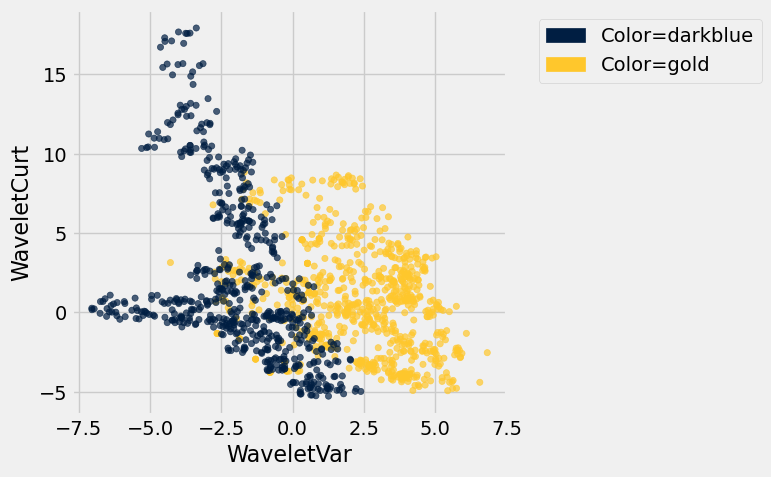

In [40]:
banknotes.scatter('WaveletVar', 'WaveletCurt', group='Color')

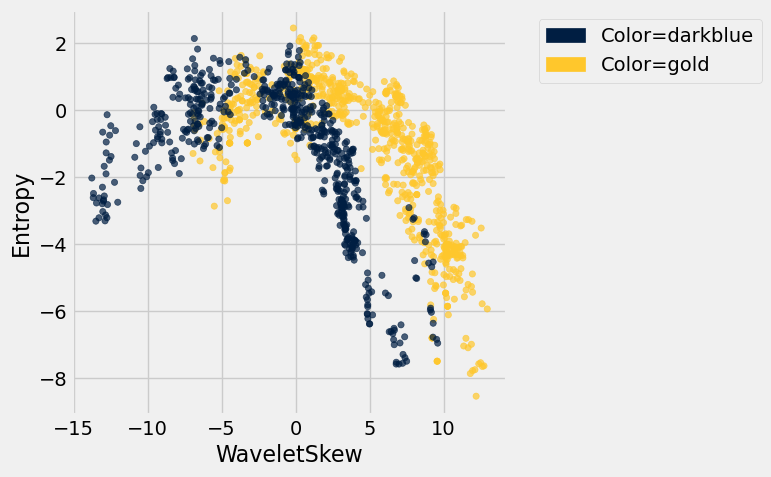

In [41]:
banknotes.scatter('WaveletSkew', 'Entropy', group='Color')

# Multiple attributes

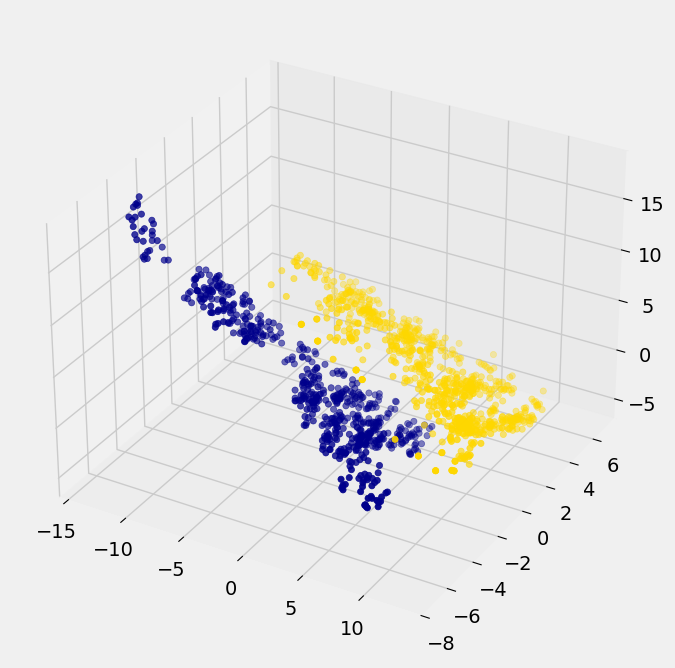

In [42]:
ax = plots.figure(figsize=(8,8)).add_subplot(111, projection='3d')
ax.scatter(banknotes.column('WaveletSkew'), 
           banknotes.column('WaveletVar'), 
           banknotes.column('WaveletCurt'), 
           c=banknotes.column('Color'));

To sum up: you now know how to use k-nearest neighbor classification to predict the answer to a yes/no question, based on the values of some attributes, assuming you have a training set with examples where the correct prediction is known. The general roadmap is this:<br>

- identify some attributes that you think might help you predict the answer to the question.

- Gather a training set of examples where you know the values of the attributes as well as the correct prediction.

- To make predictions in the future, measure the value of the attributes and then use k-nearest neighbor classification to predict the answer to the question.

# Distance in Multiple Dimensions
Use the same code for distance in mulitiple dimensions.

In [43]:
wine = Table.read_table('wine.csv')

# For converting Class to binary

def is_one(x):
    if x == 1:
        return 1
    else:
        return 0
    
wine = wine.with_column('Class', wine.apply(is_one, 0))

In [44]:
wine.show()

Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline,Class
1,14.23,1.71,2.43,15.6,127,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.2,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.4,1050,1
1,13.16,2.36,2.67,18.6,101,2.8,3.24,0.3,2.81,5.68,1.03,3.17,1185,1
1,14.37,1.95,2.5,16.8,113,3.85,3.49,0.24,2.18,7.8,0.86,3.45,1480,1
1,13.24,2.59,2.87,21,118,2.8,2.69,0.39,1.82,4.32,1.04,2.93,735,1
1,14.2,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450,1
1,14.39,1.87,2.45,14.6,96,2.5,2.52,0.3,1.98,5.25,1.02,3.58,1290,1
1,14.06,2.15,2.61,17.6,121,2.6,2.51,0.31,1.25,5.05,1.06,3.58,1295,1
1,14.83,1.64,2.17,14,97,2.8,2.98,0.29,1.98,5.2,1.08,2.85,1045,1
1,13.86,1.35,2.27,16,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045,1


In [45]:
wine_attributes = wine.drop('Class')

In [46]:
distance(np.array(wine_attributes.row(0)), np.array(wine_attributes.row(1)))

31.265012394048398

In [47]:
distance(np.array(wine_attributes.row(0)), np.array(wine_attributes.row(177)))

506.06331975356602

In [48]:
wine_with_colors = wine.join('Class', color_table)

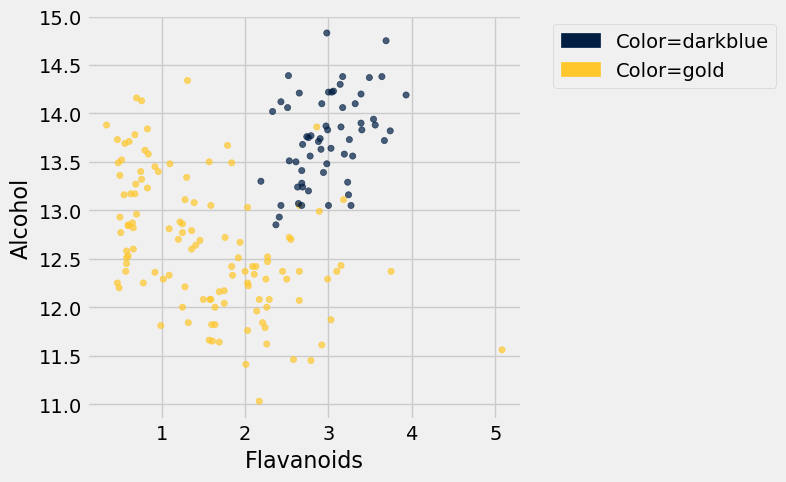

In [49]:
wine_with_colors.scatter('Flavanoids', 'Alcohol', group='Color')

In [50]:
wine_with_colors

Class,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline,Color
0,2,12.37,0.94,1.36,10.6,88,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520,gold
0,2,12.33,1.1,2.28,16,101,2.05,1.09,0.63,0.41,3.27,1.25,1.67,680,gold
0,2,12.64,1.36,2.02,16.8,100,2.02,1.41,0.53,0.62,5.75,0.98,1.59,450,gold
0,2,13.67,1.25,1.92,18,94,2.1,1.79,0.32,0.73,3.8,1.23,2.46,630,gold
0,2,12.37,1.13,2.16,19,87,3.5,3.1,0.19,1.87,4.45,1.22,2.87,420,gold
0,2,12.17,1.45,2.53,19,104,1.89,1.75,0.45,1.03,2.95,1.45,2.23,355,gold
0,2,12.37,1.21,2.56,18.1,98,2.42,2.65,0.37,2.08,4.6,1.19,2.3,678,gold
0,2,13.11,1.01,1.7,15,78,2.98,3.18,0.26,2.28,5.3,1.12,3.18,502,gold
0,2,12.37,1.17,1.92,19.6,78,2.11,2,0.27,1.04,4.68,1.12,3.48,510,gold
0,2,13.34,0.94,2.36,17,110,2.53,1.3,0.55,0.42,3.17,1.02,1.93,750,gold


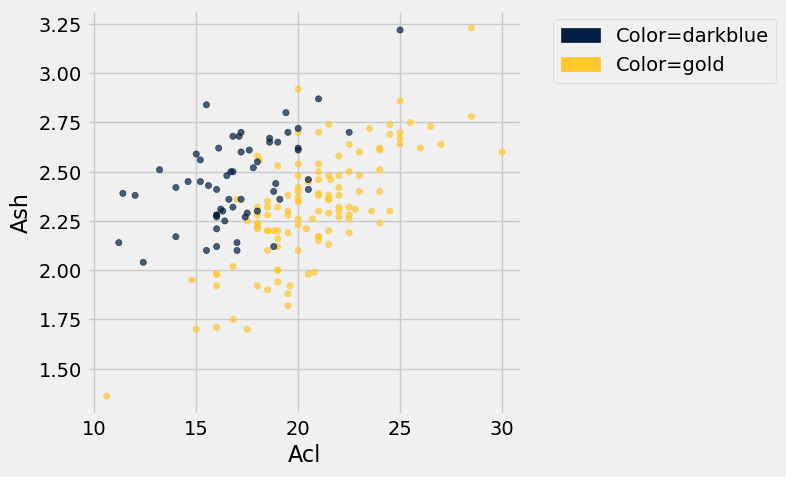

In [51]:
wine_with_colors.scatter('Acl', 'Ash', group='Color')

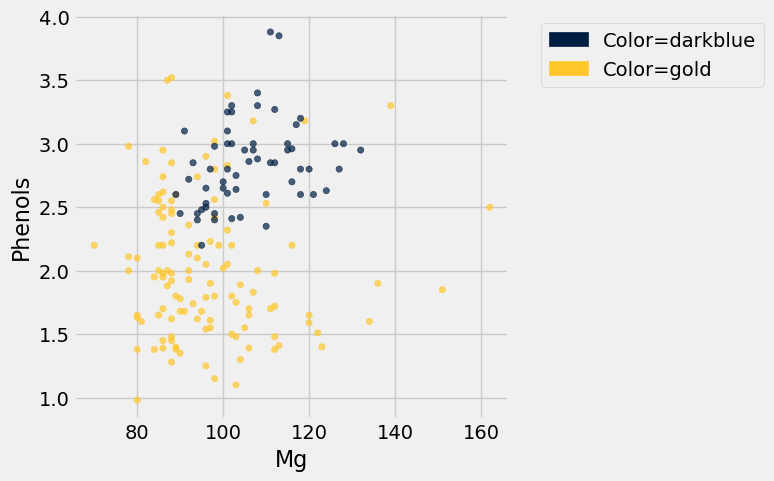

In [52]:
wine_with_colors.scatter('Mg', 'Phenols', group='Color')

In [53]:
# Step 1 Implementation - find the distance

def distance(point1, point2):
    """Returns the distance between point1 and point2
    where each argument is an array 
    consisting of the coordinates of the point"""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, new_point):
    """Returns an array of distances
    between each point in the training set
    and the new point (which is a row of attributes)"""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(np.array(new_point), np.array(row))
    return attributes.apply(distance_from_point)

def table_with_distances(training, new_point):
    """Augments the training table 
    with a column of distances from new_point"""
    return training.with_column('Distance', all_distances(training, new_point))

def closest(training, new_point, k):
    """Returns a table of the k rows of the augmented table
    corresponding to the k smallest distances"""
    with_dists = table_with_distances(training, new_point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

In [54]:
special_wine = wine.drop('Class').row(0)
special_wine

Row(Wine=1, Alcohol=14.23, Malic.acid=1.71, Ash=2.4300000000000002, Acl=15.6, Mg=127, Phenols=2.7999999999999998, Flavanoids=3.0600000000000001, Nonflavanoid.phenols=0.28000000000000003, Proanth=2.29, Color.int=5.6399999999999997, Hue=1.04, OD=3.9199999999999999, Proline=1065)

In [55]:
closest(wine, special_wine, 5)

Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline,Class,Distance
1,14.23,1.71,2.43,15.6,127,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065,1,0
1,13.74,1.67,2.25,16.4,118,2.6,2.9,0.21,1.62,5.85,0.92,3.2,1060,1,10.3928
1,14.21,4.04,2.44,18.9,111,2.85,2.65,0.3,1.25,5.24,0.87,3.33,1080,1,22.3407
1,14.1,2.02,2.4,18.8,103,2.75,2.92,0.32,2.38,6.2,1.07,2.75,1060,1,24.7602
1,14.38,3.59,2.28,16,102,3.25,3.17,0.27,2.19,4.9,1.04,3.44,1065,1,25.0947


In [56]:
# Step 2 and 3
def majority(topkclasses):
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, new_point, k):
    closestk = closest(training, new_point, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

In [57]:
classify(wine, special_wine, 5)

1

In [58]:
special_wine = wine.drop('Class').row(177)
classify(wine, special_wine, 5)

0

# Accuracy of the Classifier
Testing data set is sometimes called hold-out set.  The test data set set aside to  use to test if the training data set did a good job.

In [59]:
shuffled_wine = wine.sample(with_replacement=False) 
training_set = shuffled_wine.take(np.arange(89))
test_set  = shuffled_wine.take(np.arange(89, 178))

In [60]:
def count_zero(array):
    """Counts the number of 0's in an array"""
    return len(array) - np.count_nonzero(array)

def count_equal(array1, array2):
    """Takes two numerical arrays of equal length
    and counts the indices where the two are equal"""
    return count_zero(array1 - array2)

def evaluate_accuracy(training, test, k):
    test_attributes = test.drop('Class')
    def classify_testrow(row):
        return classify(training, row, k)
    c = test_attributes.apply(classify_testrow)
    return count_equal(c, test.column('Class')) / test.num_rows

In [61]:
evaluate_accuracy(training_set, test_set, 5)

0.9101123595505618

# Breast Cancer Diagnosis

In [62]:
patients = Table.read_table('breast-cancer.csv').drop('ID')
patients

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,1,1,1,2,1,3,1,1,0
5,4,4,5,7,10,3,2,1,0
3,1,1,1,2,2,3,1,1,0
6,8,8,1,3,4,3,7,1,0
4,1,1,3,2,1,3,1,1,0
8,10,10,8,7,10,9,7,1,1
1,1,1,1,2,10,3,1,1,0
2,1,2,1,2,1,3,1,1,0
2,1,1,1,2,1,1,1,5,0
4,2,1,1,2,1,2,1,1,0


In [63]:
# pick two attributes adn plot them
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
patients_with_colors = patients.join('Class', color_table)

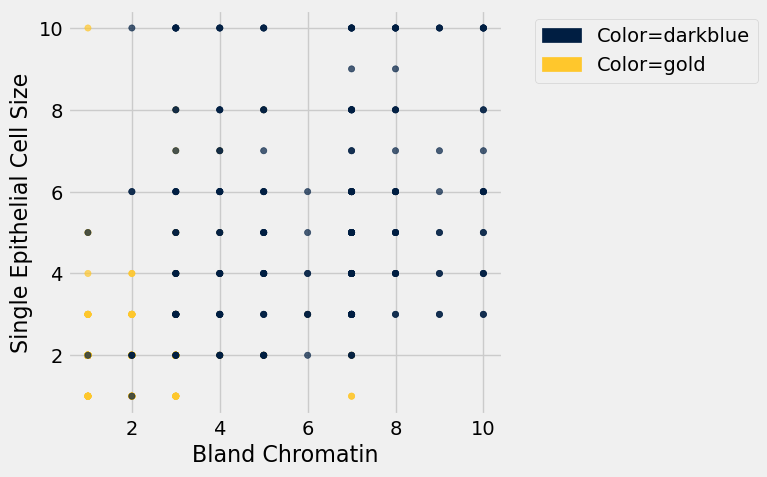

In [64]:
patients_with_colors.scatter('Bland Chromatin', 'Single Epithelial Cell Size', group='Color')

To get a better ideal of what is overlapping we create randomness in the points
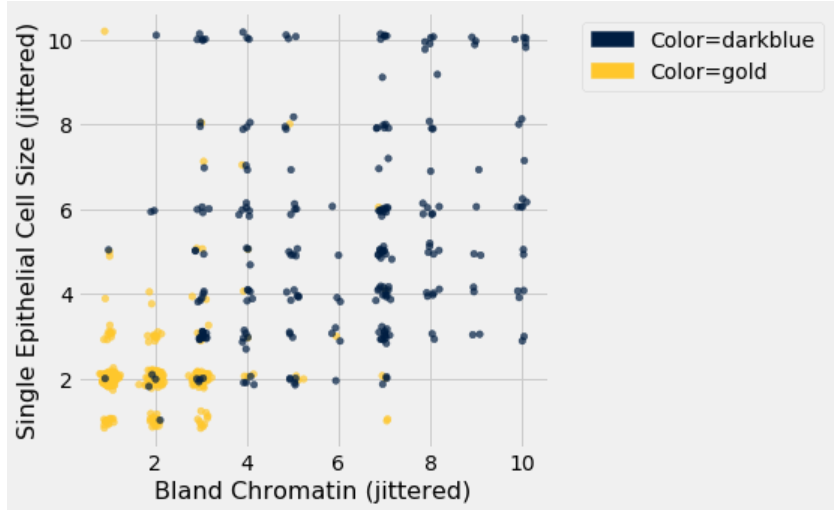

In [65]:
# separate into two data sets

shuffled_patients = patients.sample(683, with_replacement=False) 
training_set = shuffled_patients.take(np.arange(342))
test_set  = shuffled_patients.take(np.arange(342, 683))

In [66]:
evaluate_accuracy(training_set, test_set, 5)

0.95601173020527863

# Multiple Regression
predicting quantitative variable using multiple linear regression

In [67]:
all_sales = Table.read_table('AmesHousing.csv')
sales = all_sales.where('Bldg Type', '1Fam').where('Sale Condition', 'Normal').select(
    'SalePrice', '1st Flr SF', '2nd Flr SF', 
    'Total Bsmt SF', 'Garage Area', 
    'Wood Deck SF', 'Open Porch SF', 'Lot Area', 
    'Year Built', 'Yr Sold')
sales.sort('SalePrice')

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
35000,498,0,498,216,0,0,8088,1922,2006
39300,334,0,0,0,0,0,5000,1946,2007
40000,649,668,649,250,0,54,8500,1920,2008
45000,612,0,0,308,0,0,5925,1940,2009
52000,729,0,270,0,0,0,4130,1935,2008
52500,693,0,693,0,0,20,4118,1941,2006
55000,723,363,723,400,0,24,11340,1920,2008
55000,796,0,796,0,0,0,3636,1922,2008
57625,810,0,0,280,119,24,21780,1910,2009
58500,864,0,864,200,0,0,8212,1914,2010


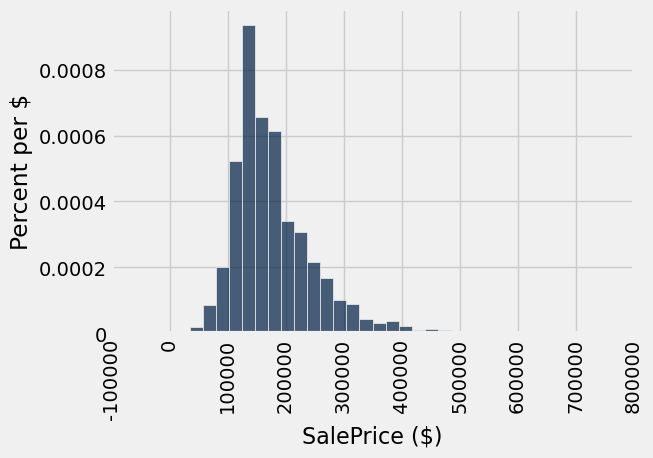

In [68]:
sales.hist('SalePrice', bins=32, unit='$')

# Correlation
1st Floor square footage and SalePrice


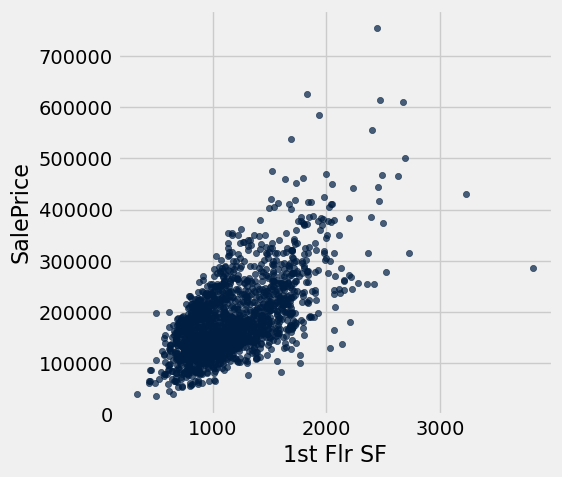

In [69]:
sales.scatter('1st Flr SF', 'SalePrice')

In [70]:
def standard_units(arr):
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)


In [71]:
correlation(sales, 'SalePrice', '1st Flr SF')

0.64246625410302249

In [72]:
for label in sales.labels:
    print('Correlation of', label, 'and SalePrice:\t', correlation(sales, label, 'SalePrice'))

Correlation of SalePrice and SalePrice:	 1.0
Correlation of 1st Flr SF and SalePrice:	 0.642466254103
Correlation of 2nd Flr SF and SalePrice:	 0.35752189428
Correlation of Total Bsmt SF and SalePrice:	 0.652978626757
Correlation of Garage Area and SalePrice:	 0.638594485252
Correlation of Wood Deck SF and SalePrice:	 0.352698666195
Correlation of Open Porch SF and SalePrice:	 0.336909417026
Correlation of Lot Area and SalePrice:	 0.290823455116
Correlation of Year Built and SalePrice:	 0.565164753714
Correlation of Yr Sold and SalePrice:	 0.0259485790807


In [73]:
both_floors = sales.column(1) + sales.column(2)
correlation(sales.with_column('Both Floors', both_floors), 'SalePrice', 'Both Floors')

0.7821920556134877

In [74]:
# Split data into training and test data sets
train, test = sales.split(1001)
print(train.num_rows, 'training and', test.num_rows, 'test instances.')

1001 training and 1001 test instances.


In [75]:
# slopes for each attribute in Multiple Linear regression
#  y = bo + b1x1 + b2x2 + b3x3.....+ bnxn


def predict(slopes, row):
    return sum(slopes * np.array(row))

example_row = test.drop('SalePrice').row(0)
print('Predicting sale price for:', example_row)

# Randomly assigns values to the slope for each attribute or variable
example_slopes = np.random.normal(10, 1, len(example_row))


print('Using slopes:', example_slopes)
print('Result:', predict(example_slopes, example_row))

Predicting sale price for: Row(1st Flr SF=816, 2nd Flr SF=0, Total Bsmt SF=816.0, Garage Area=432.0, Wood Deck SF=0, Open Porch SF=0, Lot Area=5890, Year Built=1930, Yr Sold=2008)
Using slopes: [  9.87636389  10.35195914  10.90118062   9.57144577   9.14641377
  10.03312473  10.25316769   9.02930508   9.29427106]
Result: 117569.953669


In [76]:
print('Actual sale price:', test.column('SalePrice').item(0))
print('Predicted sale price using random slopes:', predict(example_slopes, example_row))

Actual sale price: 120500
Predicted sale price using random slopes: 117569.953669


In [77]:
train_prices = train.column(0)
train_attributes = train.drop(0)

def rmse(slopes, attributes, prices):
    errors = []
    for i in np.arange(len(prices)):
        predicted = predict(slopes, attributes.row(i))
        actual = prices.item(i)
        errors.append((predicted - actual) ** 2)
    return np.mean(errors) ** 0.5

def rmse_train(slopes):
    return rmse(slopes, train_attributes, train_prices)

print('RMSE of all training examples using random slopes:', rmse_train(example_slopes))

RMSE of all training examples using random slopes: 74007.5524194


In [78]:
best_slopes = minimize(rmse_train, start=example_slopes, smooth=True, array=True)
print('The best slopes for the training set:')
Table(train_attributes.labels).with_row(list(best_slopes)).show()
print('RMSE of all training examples using the best slopes:', rmse_train(best_slopes))

The best slopes for the training set:


1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
68.9292,74.4677,53.8814,50.6191,32.7477,1.14712,0.806947,522.499,-520.439


RMSE of all training examples using the best slopes: 31474.8900739


# Interpreting Mutliple Regression
When predictng the SalePrice the 1st Flr SF * $69  per sq ft, $73 per sq ft of 2nd floor square foot, and $43 per basement square foot.  The best estimate is pff bu $30,000 from the actual sales price.

In [80]:
test_prices = test.column(0)
test_attributes = test.drop(0)

def rmse_test(slopes):
    return rmse(slopes, test_attributes, test_prices)

rmse_linear = rmse_test(best_slopes)
print('Test set RMSE for multiple linear regression:', rmse_linear)

Test set RMSE for multiple linear regression: 30838.6959103


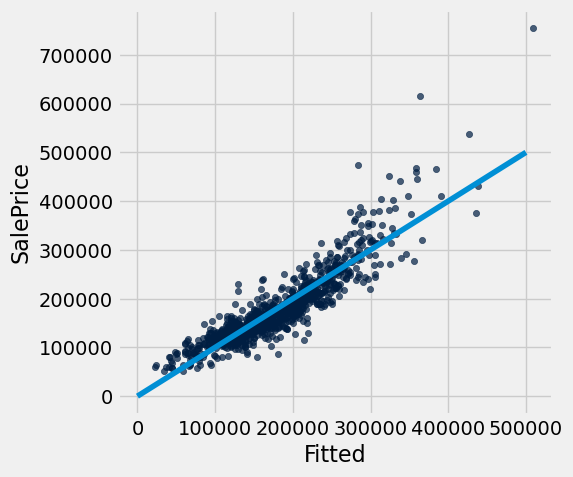

In [81]:
def fit(row):
    return sum(best_slopes * np.array(row))

test.with_column('Fitted', test.drop(0).apply(fit)).scatter('Fitted', 0)
plots.plot([0, 5e5], [0, 5e5]);

# Residual plot


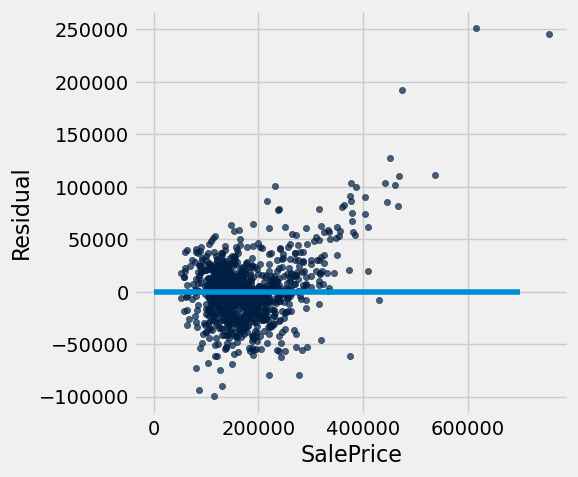

In [82]:
test.with_column('Residual', test_prices-test.drop(0).apply(fit)).scatter(0, 'Residual')
plots.plot([0, 7e5], [0, 0]);

# Nearest Neighbors for Regression
Using attributes with highest correlation

In [83]:
train_nn = train.select(0, 1, 2, 3, 4, 8)
test_nn = test.select(0, 1, 2, 3, 4, 8)
train_nn.show(3)

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built
163000,1040,0,1040,480,1967
229000,1377,806,1204,786,1988
187500,1453,0,1453,530,1961


In [84]:
def distance(pt1, pt2):
    """The distance between two points, represented as arrays."""
    return np.sqrt(sum((pt1 - pt2) ** 2))

def row_distance(row1, row2):
    """The distance between two rows of a table."""
    return distance(np.array(row1), np.array(row2))

def distances(training, example, output):
    """Compute the distance from example for each row in training."""
    dists = []
    attributes = training.drop(output)
    for row in attributes.rows:
        dists.append(row_distance(row, example))
    return training.with_column('Distance', dists)

def closest(training, example, k, output):
    """Return a table of the k closest neighbors to example."""
    return distances(training, example, output).sort('Distance').take(np.arange(k))

example_nn_row = test_nn.drop(0).row(0)
closest(train_nn, example_nn_row, 5, 'SalePrice')

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built,Distance
126000,856,0,856,399,1939,66.106
93850,768,0,768,440,1930,68.352
135000,864,0,864,420,1961,75.5844
118000,864,0,864,399,1958,80.5047
124500,864,0,864,463,1970,84.6699


In [85]:
def predict_nn(example):
    """Return the majority class among the k nearest neighbors."""
    return np.average(closest(train_nn, example, 5, 'SalePrice').column('SalePrice'))

predict_nn(example_nn_row)

119470.0

In [86]:
# is it close to the true sales price
print('Actual sale price:', test_nn.column('SalePrice').item(0))
print('Predicted sale price using nearest neighbors:', predict_nn(example_nn_row))

Actual sale price: 120500
Predicted sale price using nearest neighbors: 119470.0


# Evaluation

In [87]:
nn_test_predictions = test_nn.drop('SalePrice').apply(predict_nn)
rmse_nn = np.mean((test_prices - nn_test_predictions) ** 2) ** 0.5

print('Test set RMSE for multiple linear regression: ', rmse_linear)
print('Test set RMSE for nearest neighbor regression:', rmse_nn)

Test set RMSE for multiple linear regression:  30838.6959103
Test set RMSE for nearest neighbor regression: 32383.9045016


For these data, the errors of the two techniques are quite similar! For different data sets, one technique might outperform another. By computing the RMSE of both techniques on the same data, we can compare methods fairly. One note of caution: the difference in performance might not be due to the technique at all; it might be due to the random variation due to sampling the training and test sets in the first place.

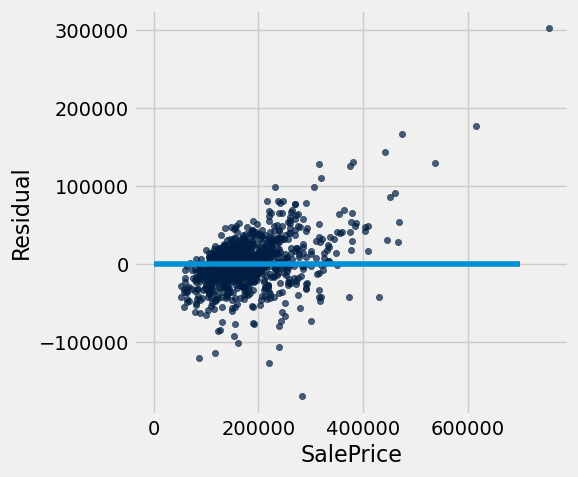

In [88]:
test.with_column('Residual', test_prices-nn_test_predictions).scatter(0, 'Residual')
plots.plot([0, 7e5], [0, 0]);

Finally, we can draw a residual plot for these predictions. We still underestimate the prices of the most expensive houses, but the bias does not appear to be as systematic. However, fewer residuals are very close to zero, indicating that fewer prices were predicted with very high accuracy.